In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cwgp.cwgp import CWGP
from cwgp.kernel import RBF
import GPy
import numpy as np

In [2]:
def mean_func(x,df,window_size=3):
#     out = 1/(1+np.exp(x))
#     out = ph.rolling(window=window_size,min_periods=1).mean()
    return 0.

In [3]:
CSV_FIlE = "japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

In [4]:
mf = GPy.core.Mapping(1,1)
mf.f = lambda x: mean_func(x,df_all[age])
mf.update_gradients = lambda a,b: None

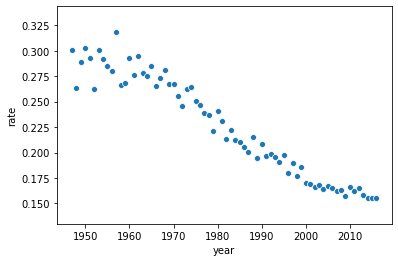

In [5]:
sns.scatterplot(df_all[age]["year"],df_all[age]["rate"])

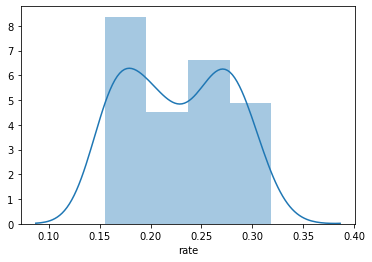

In [6]:
sns.distplot(df_all[age]["rate"])

In [7]:
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)
year = df_all[age]["year"].to_numpy().reshape(-1,1)

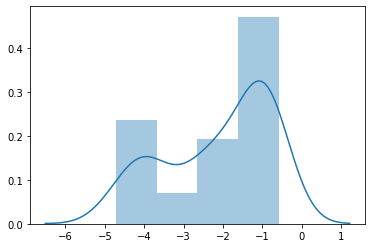

In [8]:
t_1 = CWGP("box_cox",n=2)
p_1 = t_1.fit(rate).x
x_1, d = t_1.phi.comp_phi(p_1,rate)
sns.distplot(x_1)

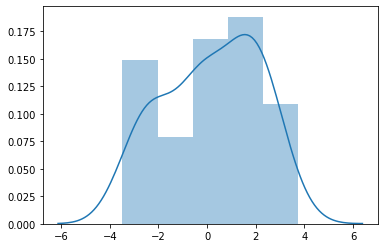

In [9]:
t_2 = CWGP("sa",n=2)
p_2 = t_2.fit(x_1).x
x_2, d = t_2.phi.comp_phi(p_2,x_1)
sns.distplot(x_2)


Name : GP regression
Objective : 42.635675139497266
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  Mat32.variance           |   17.426659110732743  |      +ve      |        
  Mat32.lengthscale        |   101.06129572017836  |      +ve      |        
  Gaussian_noise.variance  |  0.15730741273071588  |      +ve      |        


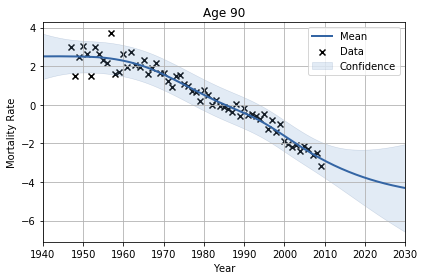

In [11]:
kernel = GPy.kern.Matern32(1)

ratio = 0.9
length = len(df_all[age])
train = int(ratio*length)
train_up, train_low = train, train-train


model_cwgp = GPy.models.GPRegression(df_all[age].year[:, None][train_low:train_up], x_2[train_low:train_up], mean_function=mf, kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])

plt.title('Age ' + str(age))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')

plt.grid(True)
plt.show()

In [19]:
model_cwgp.log_likelihood()

-42.635675139497266

In [26]:
model_cwgp.predict(np.arange(1940,2031).reshape(-1,1))[0]

array([[ 2.50679352],
       [ 2.50882479],
       [ 2.51017721],
       [ 2.51082671],
       [ 2.51074858],
       [ 2.50991747],
       [ 2.50830737],
       [ 2.50589161],
       [ 2.5028241 ],
       [ 2.49961025],
       [ 2.49543913],
       [ 2.48931861],
       [ 2.48115338],
       [ 2.47092749],
       [ 2.45741293],
       [ 2.43985591],
       [ 2.41790006],
       [ 2.39098454],
       [ 2.35861298],
       [ 2.32190876],
       [ 2.28114182],
       [ 2.2355114 ],
       [ 2.18442685],
       [ 2.12725535],
       [ 2.06407733],
       [ 1.99503225],
       [ 1.9201944 ],
       [ 1.83997796],
       [ 1.75441912],
       [ 1.66364872],
       [ 1.5684301 ],
       [ 1.46968218],
       [ 1.36834045],
       [ 1.26487582],
       [ 1.15912133],
       [ 1.0512158 ],
       [ 0.94196254],
       [ 0.83237289],
       [ 0.72347195],
       [ 0.61610338],
       [ 0.51083832],
       [ 0.40772306],
       [ 0.30706677],
       [ 0.2092763 ],
       [ 0.11432124],
       [ 0

In [11]:
data = []
start,end = 1940,2031
time_span = end-start
for i in range(start,end):
    data.append(model_cwgp.predict(np.array(i).reshape(1,-1)))
tr_data = np.array(data).reshape(-1,1,2)

 /home/chen/work/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:overflow encountered in exp


In [12]:
CI = 1.96
mean = tr_data[:,:,0]
var_upper = mean + CI*np.sqrt(tr_data[:,:,1])
var_lower = mean - CI*np.sqrt(tr_data[:,:,1])
predict_mean = t_2.phi.inv_comp_phi(p_2,mean)
predict_mean = t_1.phi.inv_comp_phi(p_1,predict_mean)
predict_var_upper = t_2.phi.inv_comp_phi(p_2,var_upper)
predict_var_upper = t_1.phi.inv_comp_phi(p_1,predict_var_upper)
predict_var_lower = t_2.phi.inv_comp_phi(p_2,var_lower)
predict_var_lower = t_1.phi.inv_comp_phi(p_1,predict_var_lower)

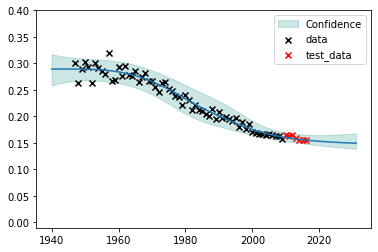

In [13]:
plt.fill_between(np.linspace(start,end,time_span),np.ravel(predict_var_upper),np.ravel(predict_var_lower),color=(0,0.5,0.5,0.2), label="Confidence")
plt.scatter(year[train_low:train_up], rate[train_low:train_up], marker="x", color='black', label="data")
plt.scatter(year[train_up:], rate[train_up:], marker="x", color='red')
plt.scatter(year[:train_low], rate[:train_low], marker="x", color='red', label="test_data")
plt.legend()
plt.ylim([-0.01,0.4])
plt.plot(np.linspace(start,end,time_span),predict_mean, label="mean")

In [14]:
n = 7
rmse = np.sqrt(np.sum((np.ravel(predict_mean[70:77])-df_all[age].rate[train_up:])**2)/n)
mae = np.sum(np.abs(np.ravel(predict_mean[70:77])-df_all[age].rate[train_up:]))/n

rmse,mae

(0.004043976499361913, 0.002970073858807626)